# 1. Install & Import 라이브러리

In [1]:
!pip3 install selenium webdriver_manager pandas numpy konlpy tensorflow

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import pandas as pd
import numpy as np
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datetime import datetime, timedelta


Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of tensorflow-intel to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata (2.6 kB)
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     --------- ------------------------------ 0.3/1.3 MB 6.3 MB/s eta 0:00:01
     ----------------- ---------------------- 0.6/1.3 MB 6.1 MB/s eta 0:00:01
     ------------------------- -------------- 0.8/1.3 MB 5.8 MB/s eta 0:00:01
     ---------------------------------- ----- 1.1/1.3 MB 6.0 MB/s eta 0:00:01
     ---------------------------------------  1.3/1.3 MB 5.6 MB/s eta 0:00:01
     ------

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.2 requires torch==2.1.2, but you have torch 1.7.1 which is incompatible.
torchvision 0.16.2+cu118 requires torch==2.1.2+cu118, but you have torch 1.7.1 which is incompatible.


# 2. 경로 설정

In [2]:
PATH_POST_DATA_CSV = 'data_csv/post.csv'
PATH_MATCH_STAT_CSV = 'data_csv/match_stats.csv'
PATH_PLAYERS_TXT = 'data_txt/players.txt'
PATH_MATCH_INFO_PNG = 'data_match_info'

# 3. 함수 설정

In [3]:
def reading_file(file_path):
    encodings = ['cp949', 'utf-8', 'ISO-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            return df
        except: pass
    return None

stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
okt = Okt()
clean_train_review = []
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
  review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
  word_review = okt.morphs(review_text,stem=True)
  if remove_stopwords:
    word_review = [token for token in word_review if not token in stop_words]
  return word_review


# 3. 저장된 데이터 수집

### 3.1. 선수 정보 불러오기

In [4]:
# 선수이름이 저장된 TXT파일 불러오기
player_box = set()
with open(PATH_PLAYERS_TXT, 'r', encoding='utf-8') as f:
    for p in f.readlines():
        player_box.add(p.strip())

# 불러온 선수 명단 출력
for i, player in enumerate(player_box):
    print(player, end = ' ')
    if (i+1)%10==0:
        print()

권창훈 김준홍 김지수 원두재 김진수 정호연 남태희 오현규 이용 고승범 
박용우 이창근 이재성 이영재 손흥민 이재익 설영우 이순민 조영욱 정승현 
김문환 문선민 황희찬 홍현석 고영준 주민규 박진섭 박지수 엄원상 송민규 
나상호 김동준 양현준 이동준 이강인 김민재 손준호 김주성 조현우 이동경 
이기제 김영권 안현범 정우영 조규성 김승규 백승호 황인범 이기혁 강성진 
이상민 김태환 조유민 이명재 강상우 김진규 윤종규 홍철 박민규 구성윤 
권경원 황의조 박규현 송범근 김동현 

### 3.2. 게시글 파일 불러오기

In [5]:
df_post = reading_file(PATH_POST_DATA_CSV)
df_post

,DATE_TIME,POST
0,2024-03-23 01:41:09,이강인 대국민사과 때 보면 그냥 손흥민은 진짜 이해가 안됨
1,2024-03-23 01:41:02,놀라운건 이게 모두
2,2024-03-23 01:41:01,창민이 요즘 제어가 안되는거 같다
3,2024-03-23 01:40:59,누가 더 잘생겼는지 평가좀
4,2024-03-23 01:40:51,헷갈리게 하는 여사친 만나고 왔는데..txt
...,...,...
39753,2022-12-30 23:59:56,"조지나 대리모 아들은 아르헨,포국 이중국적이잖음"
39754,2022-12-30 23:59:46,펠레는 앞으로 한세대만 지나도 그런새끼가 있었나? 취급일걸
39755,2022-12-30 23:59:44,10아르헨 독일 경기보면 개병신수준임
39756,2022-12-30 23:59:39,오현규가 아직 어려서 셀틱 명문 이지랄하고 있는데


### 3.3. 매치 정보 불러오기

In [6]:
df_match = reading_file(PATH_MATCH_STAT_CSV)
df_match

,DATE_TIME,Stadium,Korea,Opponent,Korea_score,Oppo_score
0,2022-01-15 20:00:00,터키 안탈리아 마르단 스타디움,남자 국가대표팀,아이슬란드,5,1
1,2022-01-21 20:00:00,터키 안탈리아 마르단 스타디움,남자 국가대표팀,몰도바,4,0
2,2022-01-27 21:00:00,레바논 사이다 무니시팔스타디움,남자 국가대표팀,레바논,1,0
3,2022-02-01 23:00:00,UAE 라시드 스타디움,남자 국가대표팀,시리아,2,0
4,2022-03-24 20:00:00,대한민국 서울월드컵경기장,남자 국가대표팀,이란,2,0
...,...,...,...,...,...,...
61,2024-11-11 20:00:00,대한민국 화성종합경기타운,남자 국가대표팀,아이슬란드,1,0
62,2024-11-24 22:00:00,카타르 에듀케이션 시티 스타디움,남자 국가대표팀,우루과이,0,0
63,2024-11-28 22:00:00,카타르 에듀케이션 시티 스타디움,남자 국가대표팀,가나,2,3
64,2024-12-03 00:00:00,카타르 에듀케이션 시티 스타디움,남자 국가대표팀,포르투갈,2,1


### 3.4. 경기 시간 기준, 36시간 이내 선수이름 언급 빈도

In [7]:
# 게시글 기록 시간 범위
begin = df_post['DATE_TIME'].min()
end = df_post['DATE_TIME'].max()

# 빈도 계산
match_post = []
for i in range(len(df_match)):
    # 진행률
    progress = f'{100*(i+1)/len(df_match):.2f}'
    print(f'\r{progress}%, {i+1}/{len(df_match)}', end='')

    # 매치 정보
    match_info = df_match.iloc[i]
    match_time = match_info['DATE_TIME']

    # 집계
    if begin <= match_time <= end: # 범위 내의 데이터 한정
        # 경기시간 기준 36시간 이내 게시글 수집
        time_value = datetime.strptime(match_time, '%Y-%m-%d %H:%M:%S')
        match_time_later = str(time_value + timedelta(hours=36))
        indexes = df_post[(df_post['DATE_TIME'] >= match_time) & (df_post['DATE_TIME'] < match_time_later)].index

        # 빈도 계산   
        if len(indexes) > 0:
            frequency = {}
            for index in indexes:
                post = df_post['POST'][index]
                for word in preprocessing(post ,okt,remove_stopwords=True,stop_words= stop_words):
                    if not word in player_box:
                        continue
                    if not word in frequency:
                        frequency[word] = 1
                    frequency[word] += 1
            sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

            match_post.append([match_info, sorted_frequency])


100.00%, 66/66

# 4. 그래프 출력 -> data_match_info 로 저장

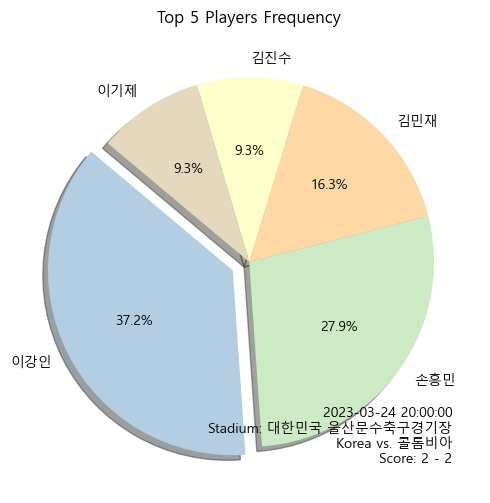

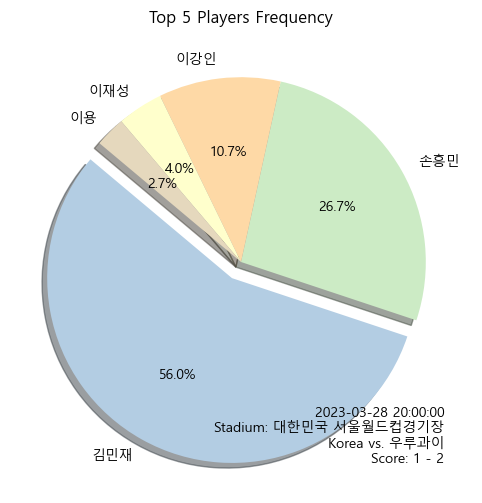

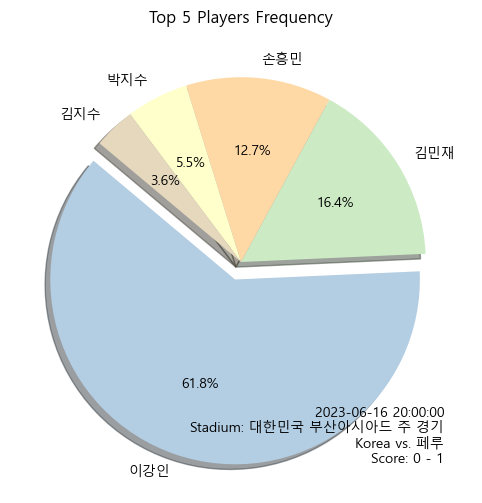

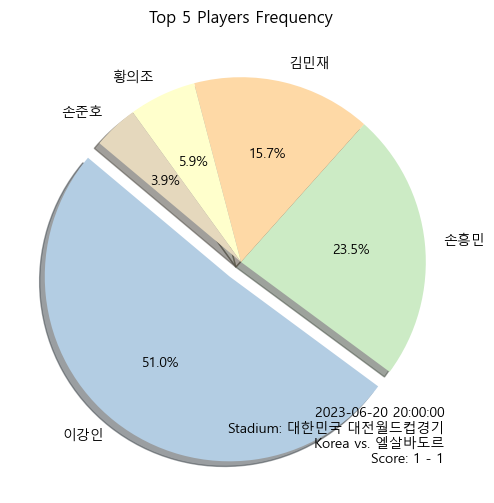

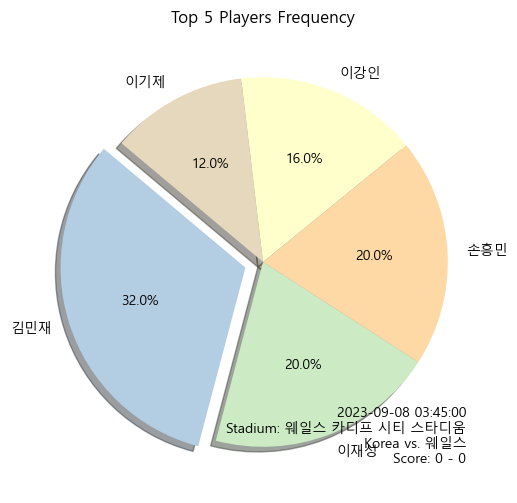

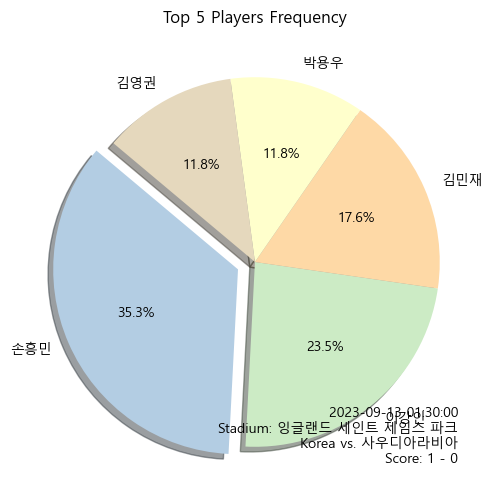

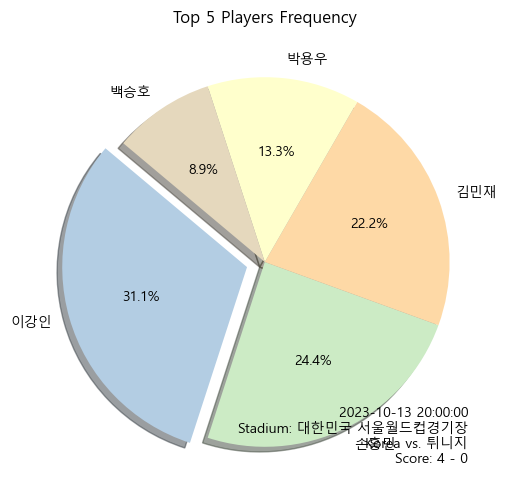

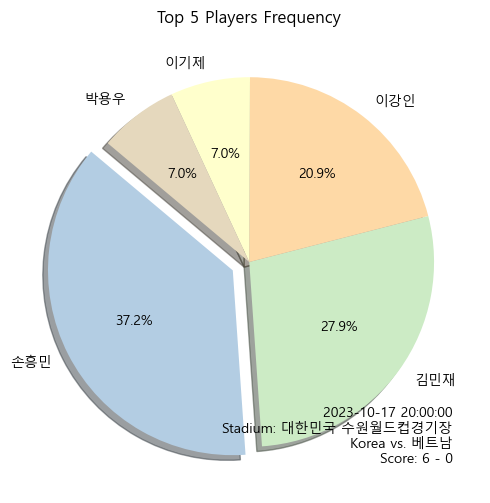

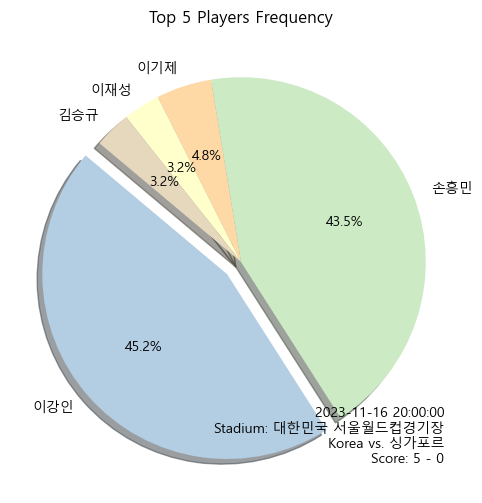

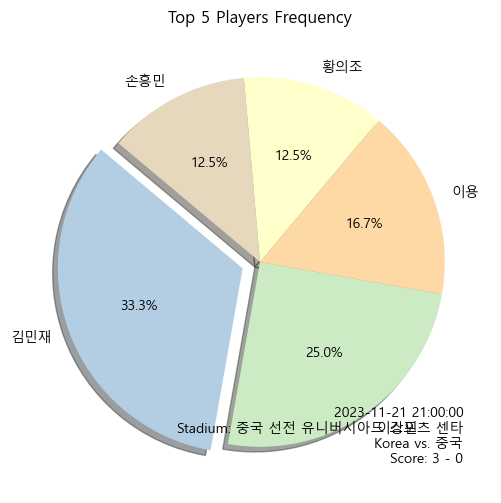

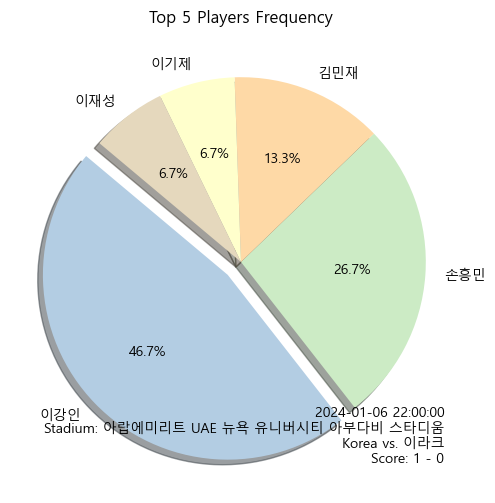

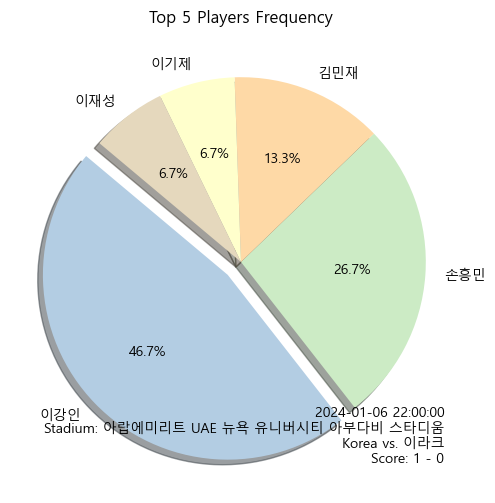

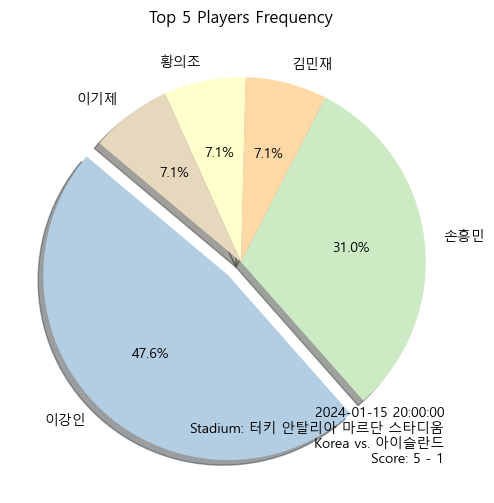

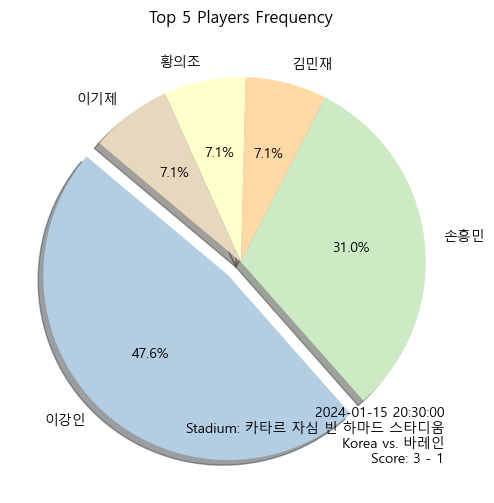

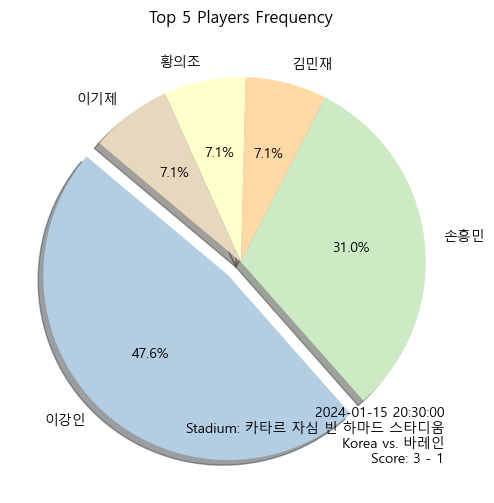

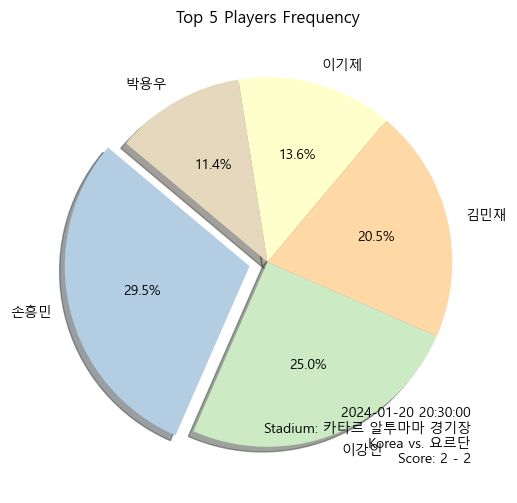

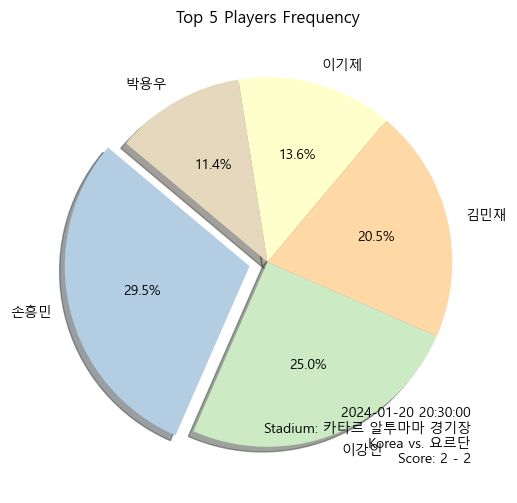

'explode' must be of length 'x'


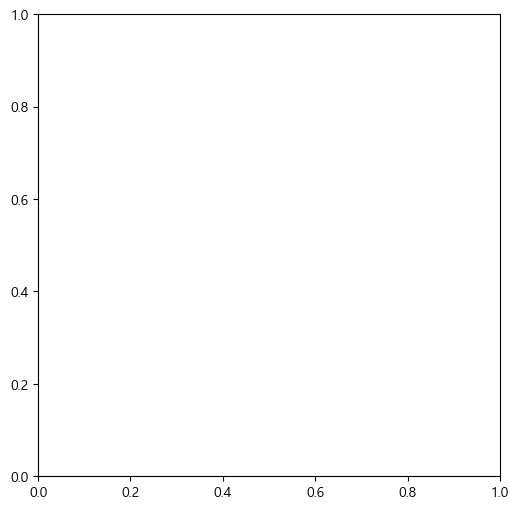

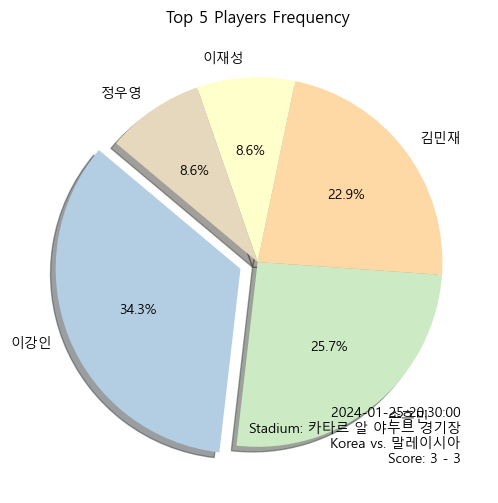

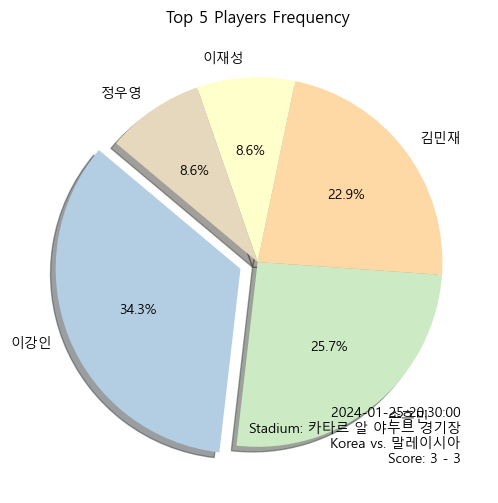

'explode' must be of length 'x'


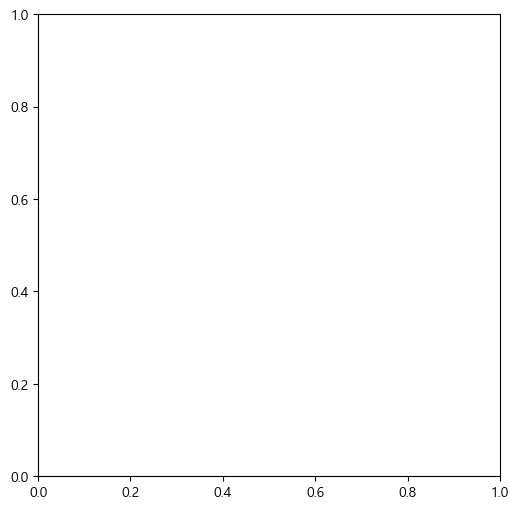

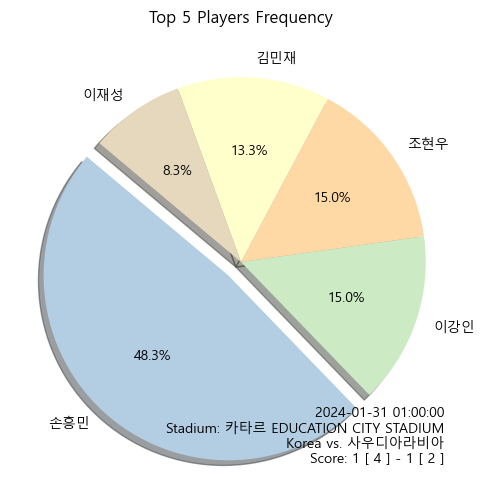

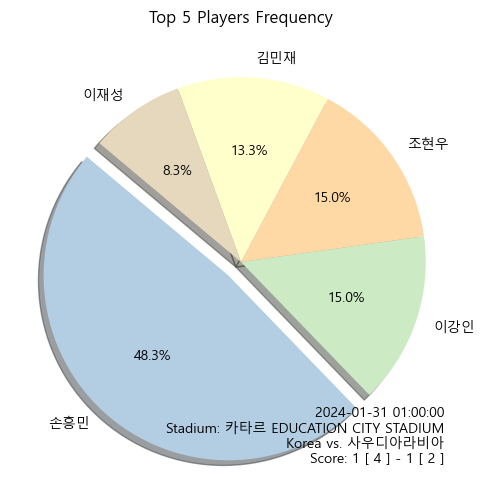

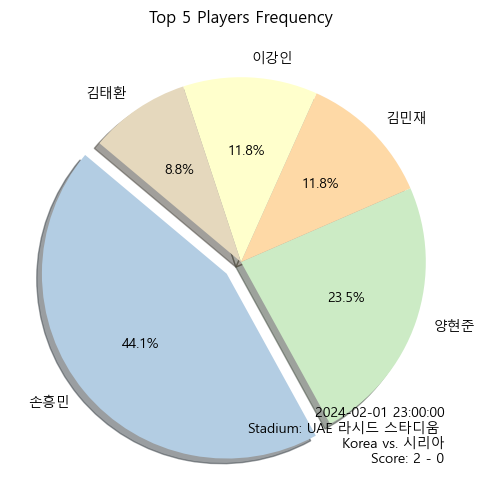

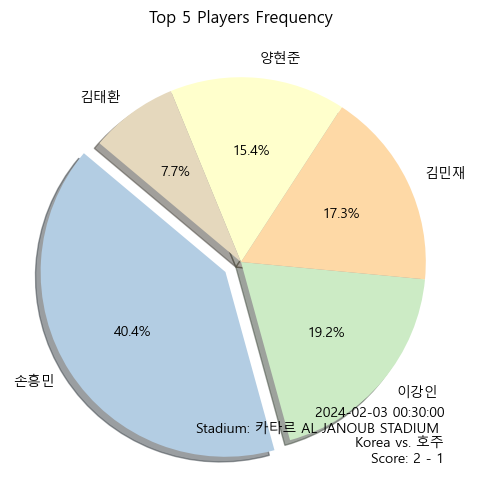

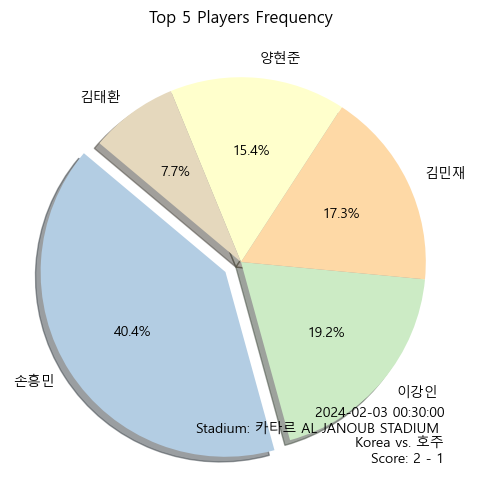

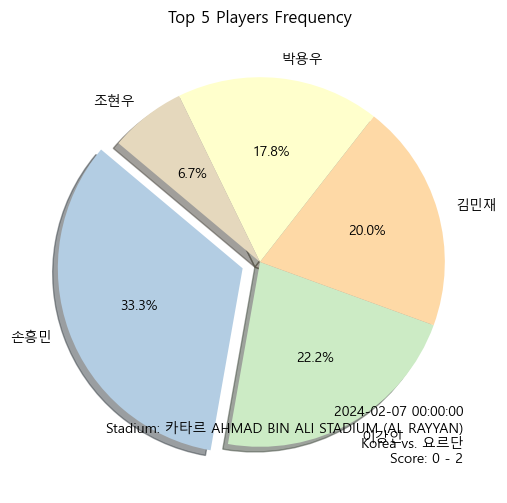

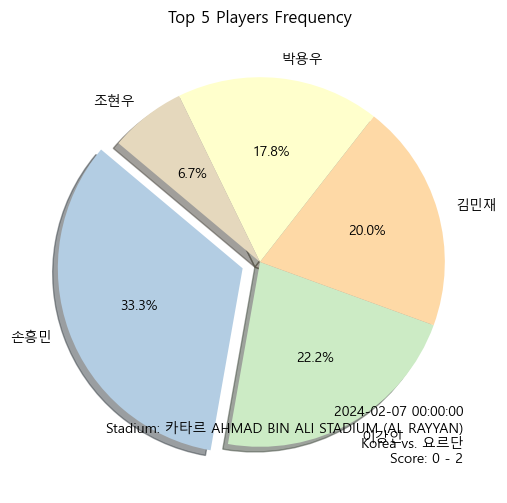

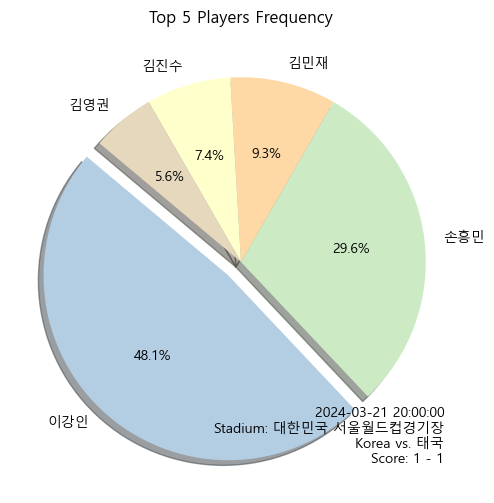

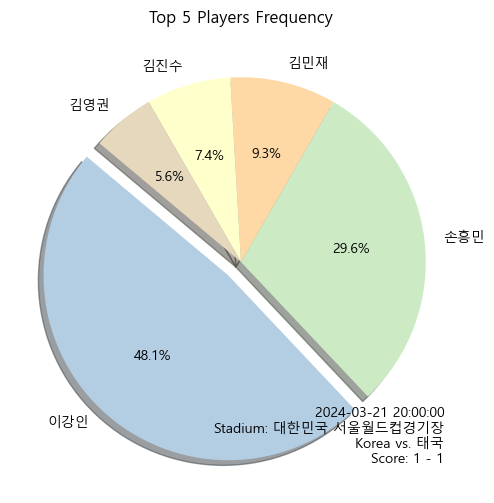

In [13]:
import matplotlib.pyplot as plt

# 한글 폰트 및 마이너스 기호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def frequency_graph(index, match_post):
    try:
        match_info, frequency = match_post[index]
        top_5 = frequency[:5]
        players, scores = zip(*top_5)

        # 그래프 설정
        plt.figure(figsize=(10, 6))  # 그래프와 텍스트 정보를 위한 공간 확보
        explode = (0.1, 0, 0, 0, 0)
        colors = plt.get_cmap('Pastel1')(np.linspace(0.2, 0.7, len(top_5)))
        
        # 파이 차트 그리기
        plt.pie(scores, labels=players, autopct='%1.1f%%', startangle=140, explode=explode, shadow=True, colors=colors)
        plt.title('Top 5 Players Frequency')
        
        # match_info 정보를 텍스트로 추가
        match_info_str = f"{match_info['DATE_TIME']}\nStadium: {match_info['Stadium']}\nKorea vs. {match_info['Opponent']}\nScore: {match_info['Korea_score']} - {match_info['Oppo_score']}"
        match_info_str = f"{match_info['DATE_TIME']}\nStadium: {match_info['Stadium']}\nKorea vs. {match_info['Opponent']}\nScore: {match_info['Korea_score']} - {match_info['Oppo_score']}"

        plt.annotate(match_info_str, xy=(1, 0), xycoords='axes fraction', fontsize=10, xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')
        
        # 파일 저장
        plt.savefig(f'{PATH_MATCH_INFO_PNG}/match_info_{index}.png', bbox_inches='tight')
        plt.show()
        plt.close()  # 현재 그림 닫기
    except Exception as e:
        print(e)

for i in range(len(match_post)):
    frequency_graph(i, match_post)
